# **Team 43: Final Project - German Traffic Sign Recognition Benchmark (GTSRB)**

***Business problem***: Electric vehicles have undergone significant advancements, with a notable
emphasis on intelligence as a key driver for their development. One prominent trend contributing
to this progress is the integration of autonomous driving systems, which are increasingly
becoming core components of electric vehicles. Recognizing that environmental perception
serves as the foundation for intelligent planning and secure decision-making in autonomous
vehicles, our focus is on advancing the innovation of traffic signs recognition. This enhancement
aims to elevate the reliability and safety of automated vehicles by bolstering their ability to
perceive and respond to traffic signs.

***Data Source***: The German Traffic Sign Recognition Benchmark (GTSRB) --- The official training and
test dataset contains images and annotations, three sets of different HOG features and Haar-like
features, Hue histograms

# Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import shutil

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Check if CUDA is available

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

# file: zip file
zip_path = '/content/drive/Shareddrives/Team 43/GTSRB_Final_Training_Images.zip'

# creat a ZipFile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # unzip to specific
    zip_ref.extractall('/content/data')

# when unzipping finish, using ls to check unzipped files.
!ls /content/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GTSRB


In [5]:
! unzip "/content/drive/Shareddrives/Team 43/GTSRB_Final_Training_Images.zip"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00003.ppm 

Split data into train and test data

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
original_data_path = '/content/data/GTSRB/Final_Training/Images'
train_path = '/content/train'
test_path = '/content/test'

# Create train and test directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Splitting function
def split_data(class_name):
    class_path = os.path.join(original_data_path, class_name)
    images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
    train_images, test_images = train_test_split(images, test_size=0.2)  # 20% for testing

    # Function to copy files
    def copy_files(files, destination):
        for file in files:
            shutil.copy(file, destination)

    # Create class directories in train and test
    train_class_dir = os.path.join(train_path, class_name)
    test_class_dir = os.path.join(test_path, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy files
    copy_files(train_images, train_class_dir)
    copy_files(test_images, test_class_dir)

# Iterate over each class and split data
for class_name in os.listdir(original_data_path):
    if os.path.isdir(os.path.join(original_data_path, class_name)):
        split_data(class_name)

We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [7]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [8]:
# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

Now we test the Image File Accessibility and Display with PIL

In [9]:
from PIL import Image

# Replace with a specific PPM file path
test_image_path = '/content/train/00000_00000.ppm'

try:
    img = Image.open(test_image_path)
    img.show()  # This will display the image if you are in a GUI environment
    print("PPM file opened successfully.")
except IOError as e:
    print(f"Error in opening PPM file: {e}")

Error in opening PPM file: [Errno 2] No such file or directory: '/content/train/00000_00000.ppm'


choose the training and test datasets

In [10]:
# choose the training and test datasets
train_dataset = datasets.ImageFolder(root='/content/train', transform=train_transform)
testset = datasets.ImageFolder('/content/test', transform = test_transform)

In [11]:
# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [12]:
# define samplers for obtaining training and validation batches
# Samples elements randomly from a given list of indices, without replacement.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
# Set up training dataset & training dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
    num_workers=num_workers,shuffle=True)

### specify the image classes

In [14]:
# specify the image classes
classes = ['Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'No passing',
            'No passing veh over 3.5 tons',
            'Right-of-way at intersection',
            'Priority road',
            'Yield',
            'Stop',
            'No vehicles',
            'Veh > 3.5 tons prohibited',
            'No entry',
            'General caution',
            'Dangerous curve left',
            'Dangerous curve right',
            'Double curve',
            'Bumpy road',
            'Slippery road',
            'Road narrows on the right',
            'Road work',
            'Traffic signals',
            'Pedestrians',
            'Children crossing',
            'Bicycles crossing',
            'Beware of ice/snow',
            'Wild animals crossing',
            'End speed + passing limits',
            'Turn right ahead',
            'Turn left ahead',
            'Ahead only',
            'Go straight or right',
            'Go straight or left',
            'Keep right',
            'Keep left',
            'Roundabout mandatory',
            'End of no passing',
            'End no passing veh > 3.5 tons']
classes

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing veh over 3.5 tons',
 'Right-of-way at intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Veh > 3.5 tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve left',
 'Dangerous curve right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End speed + passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End no passing veh > 3.5 tons']

### Visualize a Batch of Training Data

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)  # clip values to [0, 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [16]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 32x32)

(20, 3, 32, 32)

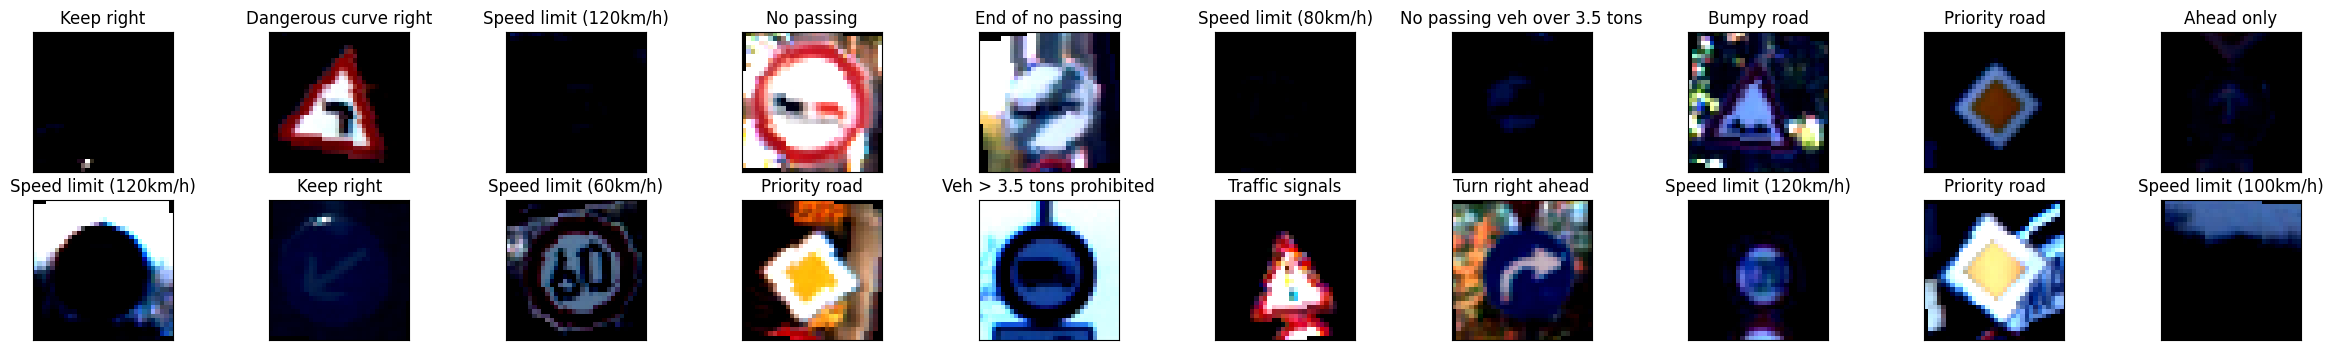

In [17]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Model Building

### Define the Network Architecture

In [18]:
# Create the network
class TrafficSignal(nn.Module):
    def __init__(self):
        super(TrafficSignal, self).__init__()
        self.fc1 = nn.Linear(1024*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 43)  # Output layer with 43 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

# Create an instance of the network
model1 = TrafficSignal()

In [19]:
model1

TrafficSignal(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=43, bias=True)
)

### Train The Network
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [20]:
# Train the network
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.003)

epochs = 30
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1)  # Flatten the input image
        #Training pass
        output=model1(images)
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 2.273000113131327
Training loss: 1.5900179884460364
Training loss: 1.2948588085564319
Training loss: 1.221320140791947
Training loss: 1.137757264992647
Training loss: 1.2266303111919377
Training loss: 1.0789979650405797
Training loss: 1.0255205891491694
Training loss: 1.0659010310611277
Training loss: 1.0137100673178165
Training loss: 0.9754860200451322
Training loss: 1.0651573165775867
Training loss: 0.9336306382820272
Training loss: 0.909245542968004
Training loss: 0.9871189102910732
Training loss: 0.8860450930525051
Training loss: 0.9044816205174063
Training loss: 0.9692787667186826
Training loss: 1.0521512251626552
Training loss: 0.9840015737455713
Training loss: 1.0189182846621272
Training loss: 0.9841715229268184
Training loss: 0.8987504164710569
Training loss: 0.9399921703947027
Training loss: 1.0344890306333892
Training loss: 0.841412512095351
Training loss: 0.9611721770032836
Training loss: 0.9423231017171291
Training loss: 0.8727724636879645
Training loss: 0.96

### Add Dropout and Weight decay

In [21]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 43)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # With dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

### Train network

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.003, weight_decay=1e-4)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        log_ps = model2(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        ## Implement the validation pass and print out the validation accuracy
        # turn off gradients
        tot_test_loss =0
        accuracy = 0  # Number of correct predictions on the test set
        with torch.no_grad():
            # set model to evalution mode
            model2.eval()
            # validation pass here
            for images, labels in test_loader:
              images=images.to(device)
              labels=labels.to(device)
              log_ps=model2(images)
              loss= criterion(log_ps, labels)
              tot_test_loss += loss.item()

              # Get the class probabilities
              ps = torch.exp(log_ps)
              top_p, top_class = ps.topk(1, dim=1)
              equals = top_class == labels.view(*top_class.shape)
              accuracy += torch.mean(equals.type(torch.FloatTensor))

        # set model back to train mode
        model2.train()
        train_loss =tot_train_loss /len(train_loader)
        test_loss = tot_test_loss / len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(accuracy / len(test_loader)))

Epoch: 1/30..  Training Loss: 3.024..  Test Loss: 2.433..  Test Accuracy: 0.255
Epoch: 2/30..  Training Loss: 2.662..  Test Loss: 2.362..  Test Accuracy: 0.273
Epoch: 3/30..  Training Loss: 2.618..  Test Loss: 2.306..  Test Accuracy: 0.292
Epoch: 4/30..  Training Loss: 2.562..  Test Loss: 2.367..  Test Accuracy: 0.282
Epoch: 5/30..  Training Loss: 2.544..  Test Loss: 2.217..  Test Accuracy: 0.309
Epoch: 6/30..  Training Loss: 2.605..  Test Loss: 2.229..  Test Accuracy: 0.348
Epoch: 7/30..  Training Loss: 2.559..  Test Loss: 2.380..  Test Accuracy: 0.271
Epoch: 8/30..  Training Loss: 2.707..  Test Loss: 2.636..  Test Accuracy: 0.306
Epoch: 9/30..  Training Loss: 2.520..  Test Loss: 2.275..  Test Accuracy: 0.298
Epoch: 10/30..  Training Loss: 2.589..  Test Loss: 2.347..  Test Accuracy: 0.284
Epoch: 11/30..  Training Loss: 2.568..  Test Loss: 2.772..  Test Accuracy: 0.206
Epoch: 12/30..  Training Loss: 2.635..  Test Loss: 2.454..  Test Accuracy: 0.266
Epoch: 13/30..  Training Loss: 2.524.

### Test the Trained Network

In [23]:
def test_model(model, dataloader):
    model.eval()

    total_size = len(dataloader.dataset)

    predictions = np.zeros(total_size)
    all_classes = np.zeros(total_size)
    all_proba = np.zeros((total_size, 43))

    i = 0
    running_loss = 0.0
    running_corrects = 0

    for inputs, classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)

        # 1. Compute outputs
        outputs = model(inputs)

        # 2. Compute loss
        loss = criterion(outputs, classes)
        _, preds = torch.max(outputs.data, dim=1)

        # Add loss and number of correct predictions
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)

        # Store the predicted class and true classes
        batch_size = len(classes)
        predictions[i:i+batch_size] = preds.to('cpu').numpy()
        all_classes[i:i+batch_size] = classes.to('cpu').numpy()

        # Store the predicted log probabilities
        all_proba[i:i+batch_size, :] = outputs.data.to('cpu').numpy()

        i += batch_size

    epoch_loss = running_loss / total_size
    epoch_acc = running_corrects.data.item() / total_size

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return predictions, all_proba, all_classes


In [24]:
predictions, all_proba, all_classes = test_model(model2,test_loader)

Loss: 0.1321 Acc: 0.2565


### Confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(43);
    plt.xticks(tick_marks, classes, rotation=90);
    plt.yticks(tick_marks, classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

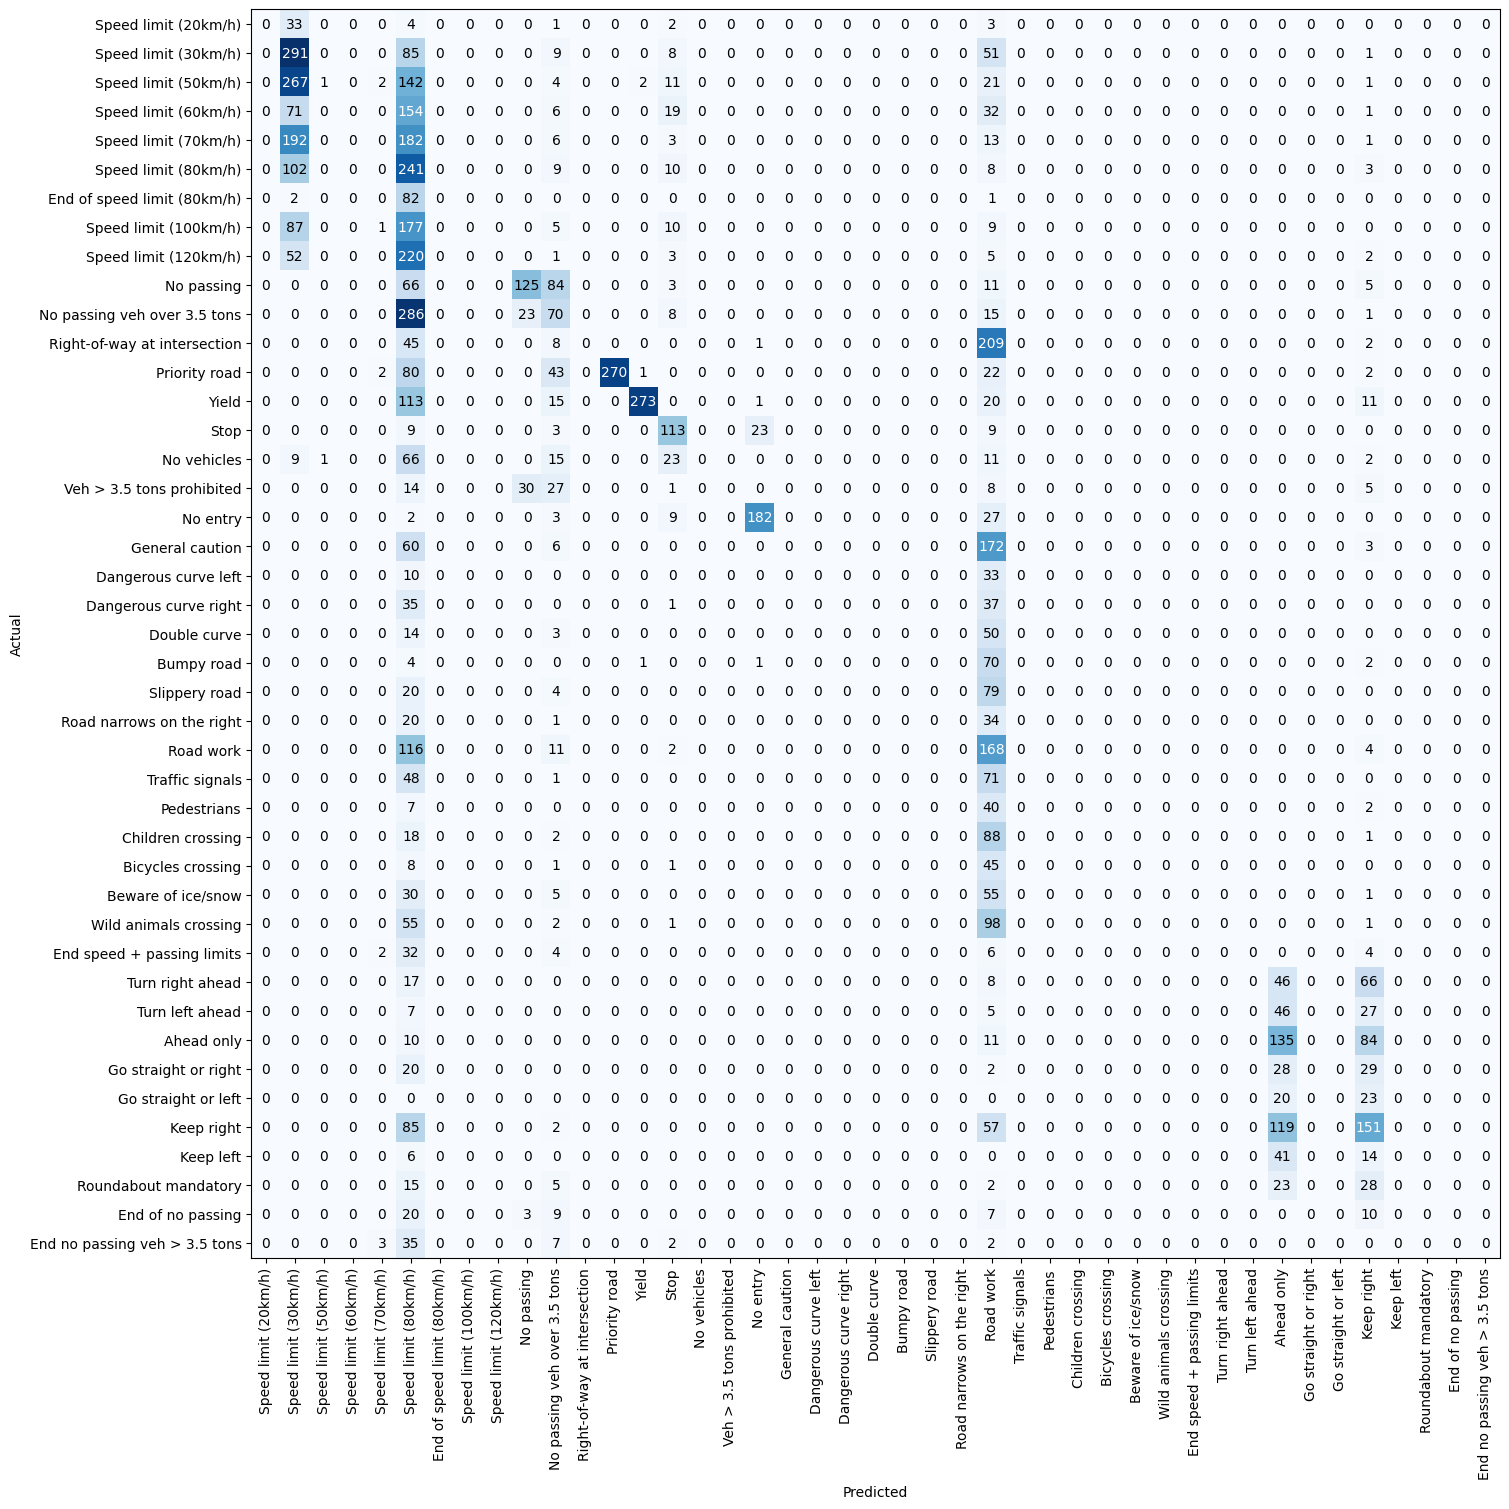

In [26]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

### Define the Network Architecture - Convolutional Neural Networks

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 43)
        self.fc2 = nn.Linear(500, 43)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [28]:
# create a complete CNN
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [29]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
# Move all model parameters to the GPU
for param in model.parameters():
    param.cuda()

### Define Loss Function and Optimizer

In [30]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the Network

In [31]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler) # divide the total samples to get the average loss
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.409292 	Validation Loss: 3.233893
Validation loss decreased (inf --> 3.233893).  Saving model ...
Epoch: 2 	Training Loss: 2.532862 	Validation Loss: 1.849515
Validation loss decreased (3.233893 --> 1.849515).  Saving model ...
Epoch: 3 	Training Loss: 1.525231 	Validation Loss: 1.120562
Validation loss decreased (1.849515 --> 1.120562).  Saving model ...
Epoch: 4 	Training Loss: 1.096332 	Validation Loss: 0.815814
Validation loss decreased (1.120562 --> 0.815814).  Saving model ...
Epoch: 5 	Training Loss: 0.829553 	Validation Loss: 0.606422
Validation loss decreased (0.815814 --> 0.606422).  Saving model ...
Epoch: 6 	Training Loss: 0.658143 	Validation Loss: 0.463876
Validation loss decreased (0.606422 --> 0.463876).  Saving model ...
Epoch: 7 	Training Loss: 0.547473 	Validation Loss: 0.410995
Validation loss decreased (0.463876 --> 0.410995).  Saving model ...
Epoch: 8 	Training Loss: 0.472547 	Validation Loss: 0.321089
Validation loss decreased (0.41099

In [32]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

### Test the Trained Network

In [33]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
size=len(testset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,43))
idx=0
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.062266

Test Accuracy of Speed limit (20km/h): 100.00% (43/43)
Test Accuracy of Speed limit (30km/h): 95.06% (423/445)
Test Accuracy of Speed limit (50km/h): 95.79% (432/451)
Test Accuracy of Speed limit (60km/h): 98.23% (278/283)
Test Accuracy of Speed limit (70km/h): 100.00% (397/397)
Test Accuracy of Speed limit (80km/h): 98.39% (367/373)
Test Accuracy of End of speed limit (80km/h): 98.82% (84/85)
Test Accuracy of Speed limit (100km/h): 94.81% (274/289)
Test Accuracy of Speed limit (120km/h): 99.29% (281/283)
Test Accuracy of No passing: 100.00% (294/294)
Test Accuracy of No passing veh over 3.5 tons: 100.00% (403/403)
Test Accuracy of Right-of-way at intersection: 98.87% (262/265)
Test Accuracy of Priority road: 100.00% (420/420)
Test Accuracy of Yield: 99.31% (430/433)
Test Accuracy of  Stop: 99.36% (156/157)
Test Accuracy of No vehicles: 100.00% (127/127)
Test Accuracy of Veh > 3.5 tons prohibited: 97.65% (83/85)
Test Accuracy of No entry: 100.00% (223/223)
Test Acc

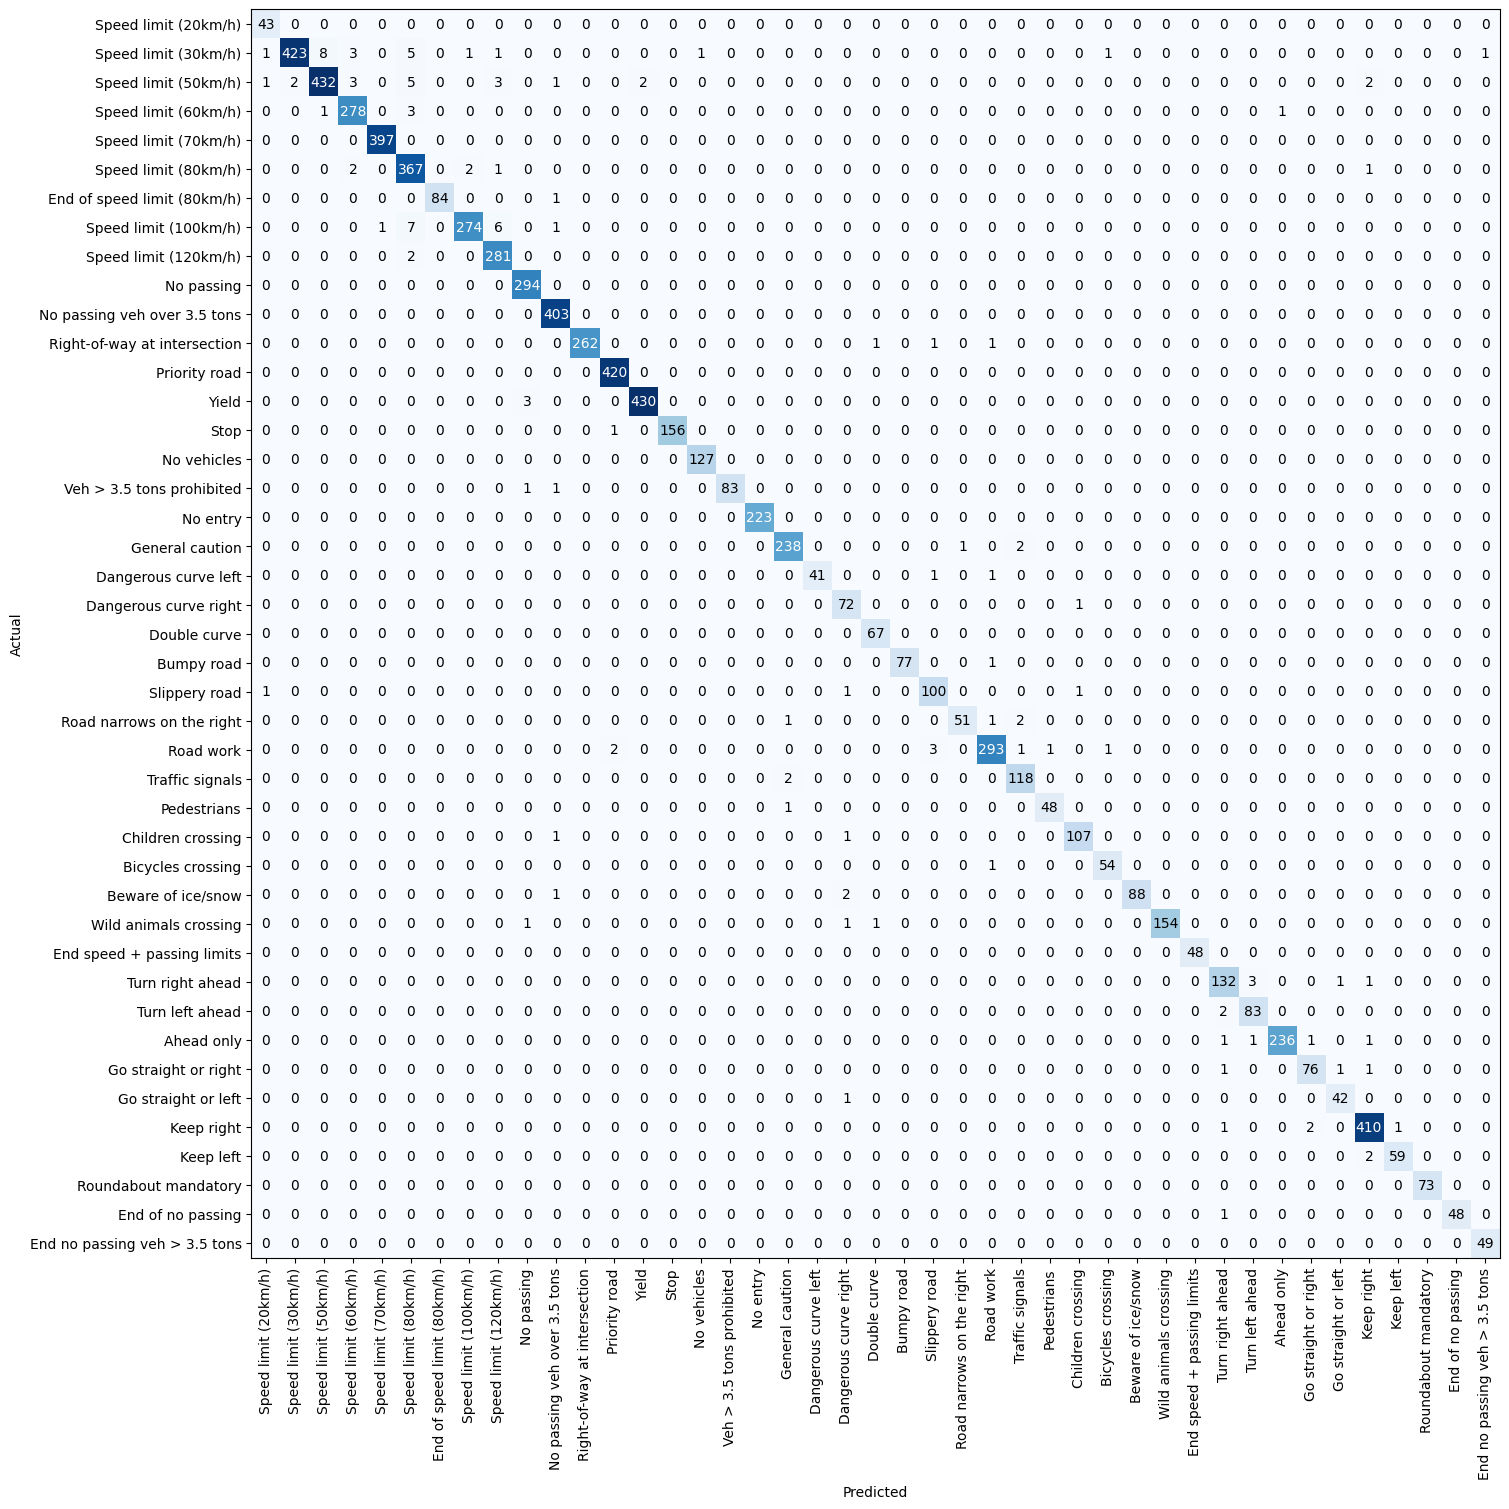

In [34]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

### Optimize Model

In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [36]:
n_epochs = 60

valid_loss_min = np.Inf


for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.102143 	Validation Loss: 0.078109
Validation loss decreased (inf --> 0.078109).  Saving model ...
Epoch: 2 	Training Loss: 0.103196 	Validation Loss: 0.105000
Epoch: 3 	Training Loss: 0.094515 	Validation Loss: 0.085451
Epoch: 4 	Training Loss: 0.093243 	Validation Loss: 0.081078
Epoch: 5 	Training Loss: 0.094931 	Validation Loss: 0.061140
Validation loss decreased (0.078109 --> 0.061140).  Saving model ...
Epoch: 6 	Training Loss: 0.083501 	Validation Loss: 0.067283
Epoch: 7 	Training Loss: 0.083326 	Validation Loss: 0.065009
Epoch: 8 	Training Loss: 0.081262 	Validation Loss: 0.065334
Epoch: 9 	Training Loss: 0.079055 	Validation Loss: 0.069182
Epoch: 10 	Training Loss: 0.072795 	Validation Loss: 0.060606
Validation loss decreased (0.061140 --> 0.060606).  Saving model ...
Epoch: 11 	Training Loss: 0.073072 	Validation Loss: 0.061320
Epoch: 12 	Training Loss: 0.070110 	Validation Loss: 0.065331
Epoch: 13 	Training Loss: 0.066316 	Validation Loss: 0.062736
E

In [37]:
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
size=len(testset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,43))
idx=0
model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)


    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.028338

Test Accuracy of Speed limit (20km/h): 100.00% (43/43)
Test Accuracy of Speed limit (30km/h): 98.65% (439/445)
Test Accuracy of Speed limit (50km/h): 97.78% (441/451)
Test Accuracy of Speed limit (60km/h): 99.29% (281/283)
Test Accuracy of Speed limit (70km/h): 100.00% (397/397)
Test Accuracy of Speed limit (80km/h): 98.39% (367/373)
Test Accuracy of End of speed limit (80km/h): 98.82% (84/85)
Test Accuracy of Speed limit (100km/h): 98.96% (286/289)
Test Accuracy of Speed limit (120km/h): 100.00% (283/283)
Test Accuracy of No passing: 100.00% (294/294)
Test Accuracy of No passing veh over 3.5 tons: 100.00% (403/403)
Test Accuracy of Right-of-way at intersection: 100.00% (265/265)
Test Accuracy of Priority road: 100.00% (420/420)
Test Accuracy of Yield: 100.00% (433/433)
Test Accuracy of  Stop: 99.36% (156/157)
Test Accuracy of No vehicles: 100.00% (127/127)
Test Accuracy of Veh > 3.5 tons prohibited: 97.65% (83/85)
Test Accuracy of No entry: 100.00% (223/223)
Test 

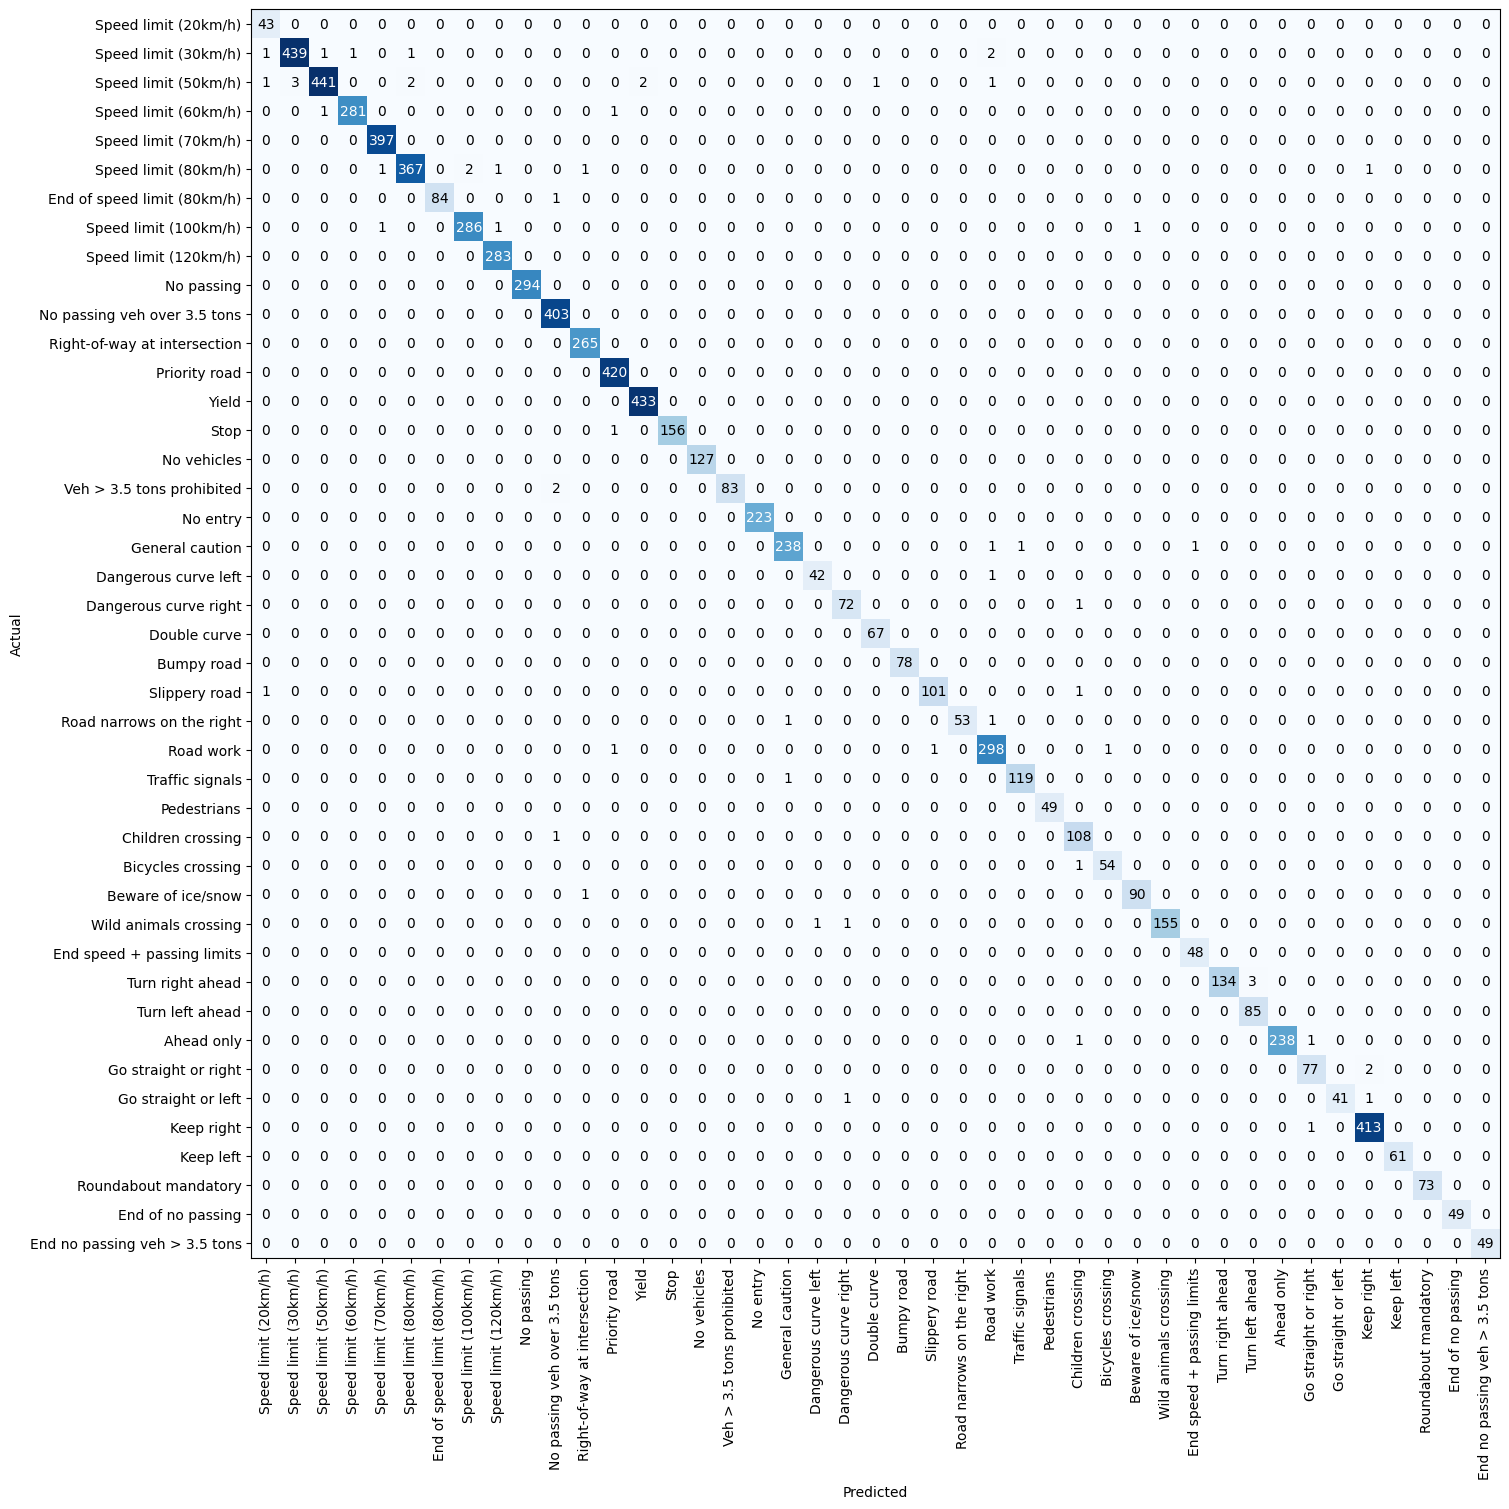

In [38]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [39]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [40]:
n_epochs = 60

valid_loss_min = np.Inf


for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.022130 	Validation Loss: 0.040118
Validation loss decreased (inf --> 0.040118).  Saving model ...
Epoch: 2 	Training Loss: 0.019356 	Validation Loss: 0.032541
Validation loss decreased (0.040118 --> 0.032541).  Saving model ...
Epoch: 3 	Training Loss: 0.018881 	Validation Loss: 0.036206
Epoch: 4 	Training Loss: 0.017916 	Validation Loss: 0.034047
Epoch: 5 	Training Loss: 0.016376 	Validation Loss: 0.037928
Epoch: 6 	Training Loss: 0.017167 	Validation Loss: 0.033520
Epoch: 7 	Training Loss: 0.016306 	Validation Loss: 0.038479
Epoch: 8 	Training Loss: 0.016374 	Validation Loss: 0.038141
Epoch: 9 	Training Loss: 0.015292 	Validation Loss: 0.034514
Epoch: 10 	Training Loss: 0.014783 	Validation Loss: 0.036769
Epoch: 11 	Training Loss: 0.015880 	Validation Loss: 0.033888
Epoch: 12 	Training Loss: 0.016044 	Validation Loss: 0.034680
Epoch: 13 	Training Loss: 0.015969 	Validation Loss: 0.034016
Epoch: 14 	Training Loss: 0.013474 	Validation Loss: 0.034540
Epoch: 1

In [41]:
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
size=len(testset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,43))
idx=0
model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)


    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.023050

Test Accuracy of Speed limit (20km/h): 100.00% (43/43)
Test Accuracy of Speed limit (30km/h): 98.65% (439/445)
Test Accuracy of Speed limit (50km/h): 98.45% (444/451)
Test Accuracy of Speed limit (60km/h): 99.65% (282/283)
Test Accuracy of Speed limit (70km/h): 99.75% (396/397)
Test Accuracy of Speed limit (80km/h): 98.93% (369/373)
Test Accuracy of End of speed limit (80km/h): 98.82% (84/85)
Test Accuracy of Speed limit (100km/h): 98.62% (285/289)
Test Accuracy of Speed limit (120km/h): 100.00% (283/283)
Test Accuracy of No passing: 100.00% (294/294)
Test Accuracy of No passing veh over 3.5 tons: 100.00% (403/403)
Test Accuracy of Right-of-way at intersection: 100.00% (265/265)
Test Accuracy of Priority road: 100.00% (420/420)
Test Accuracy of Yield: 100.00% (433/433)
Test Accuracy of  Stop: 100.00% (157/157)
Test Accuracy of No vehicles: 100.00% (127/127)
Test Accuracy of Veh > 3.5 tons prohibited: 100.00% (85/85)
Test Accuracy of No entry: 100.00% (223/223)
Test

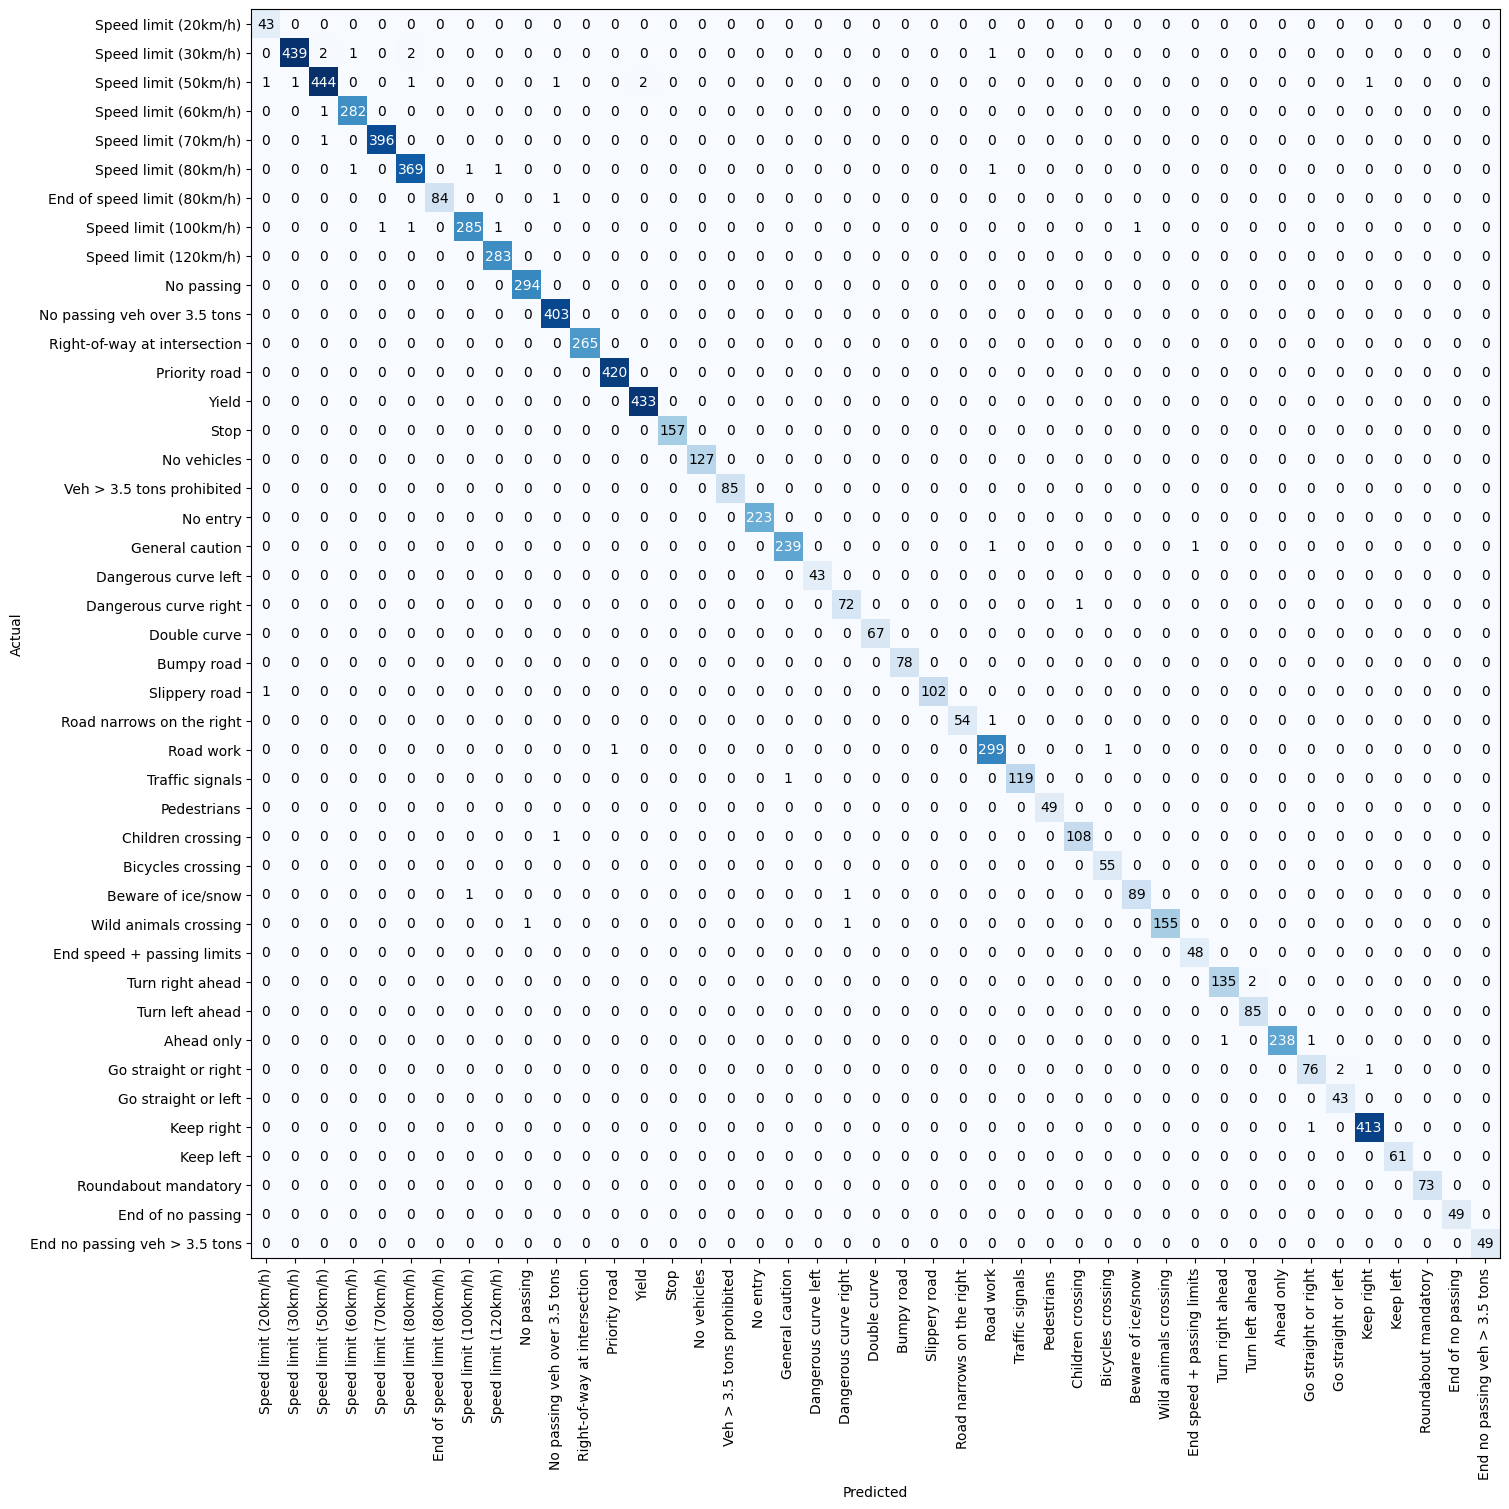

In [42]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [43]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [44]:
n_epochs = 100

valid_loss_min = np.Inf


for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.021968 	Validation Loss: 0.042823
Validation loss decreased (inf --> 0.042823).  Saving model ...
Epoch: 2 	Training Loss: 0.021341 	Validation Loss: 0.043981
Epoch: 3 	Training Loss: 0.025562 	Validation Loss: 0.047181
Epoch: 4 	Training Loss: 0.024564 	Validation Loss: 0.044667
Epoch: 5 	Training Loss: 0.024316 	Validation Loss: 0.041954
Validation loss decreased (0.042823 --> 0.041954).  Saving model ...
Epoch: 6 	Training Loss: 0.026047 	Validation Loss: 0.039156
Validation loss decreased (0.041954 --> 0.039156).  Saving model ...
Epoch: 7 	Training Loss: 0.024246 	Validation Loss: 0.045888
Epoch: 8 	Training Loss: 0.022608 	Validation Loss: 0.040424
Epoch: 9 	Training Loss: 0.025207 	Validation Loss: 0.037945
Validation loss decreased (0.039156 --> 0.037945).  Saving model ...
Epoch: 10 	Training Loss: 0.025800 	Validation Loss: 0.039418
Epoch: 11 	Training Loss: 0.024722 	Validation Loss: 0.044645
Epoch: 12 	Training Loss: 0.026475 	Validation Loss: 0.0

In [45]:
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
size=len(testset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,43))
idx=0
model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)


    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.022199

Test Accuracy of Speed limit (20km/h): 100.00% (43/43)
Test Accuracy of Speed limit (30km/h): 98.65% (439/445)
Test Accuracy of Speed limit (50km/h): 98.45% (444/451)
Test Accuracy of Speed limit (60km/h): 99.65% (282/283)
Test Accuracy of Speed limit (70km/h): 100.00% (397/397)
Test Accuracy of Speed limit (80km/h): 99.20% (370/373)
Test Accuracy of End of speed limit (80km/h): 98.82% (84/85)
Test Accuracy of Speed limit (100km/h): 98.62% (285/289)
Test Accuracy of Speed limit (120km/h): 100.00% (283/283)
Test Accuracy of No passing: 100.00% (294/294)
Test Accuracy of No passing veh over 3.5 tons: 100.00% (403/403)
Test Accuracy of Right-of-way at intersection: 100.00% (265/265)
Test Accuracy of Priority road: 100.00% (420/420)
Test Accuracy of Yield: 99.77% (432/433)
Test Accuracy of  Stop: 99.36% (156/157)
Test Accuracy of No vehicles: 100.00% (127/127)
Test Accuracy of Veh > 3.5 tons prohibited: 100.00% (85/85)
Test Accuracy of No entry: 100.00% (223/223)
Test 

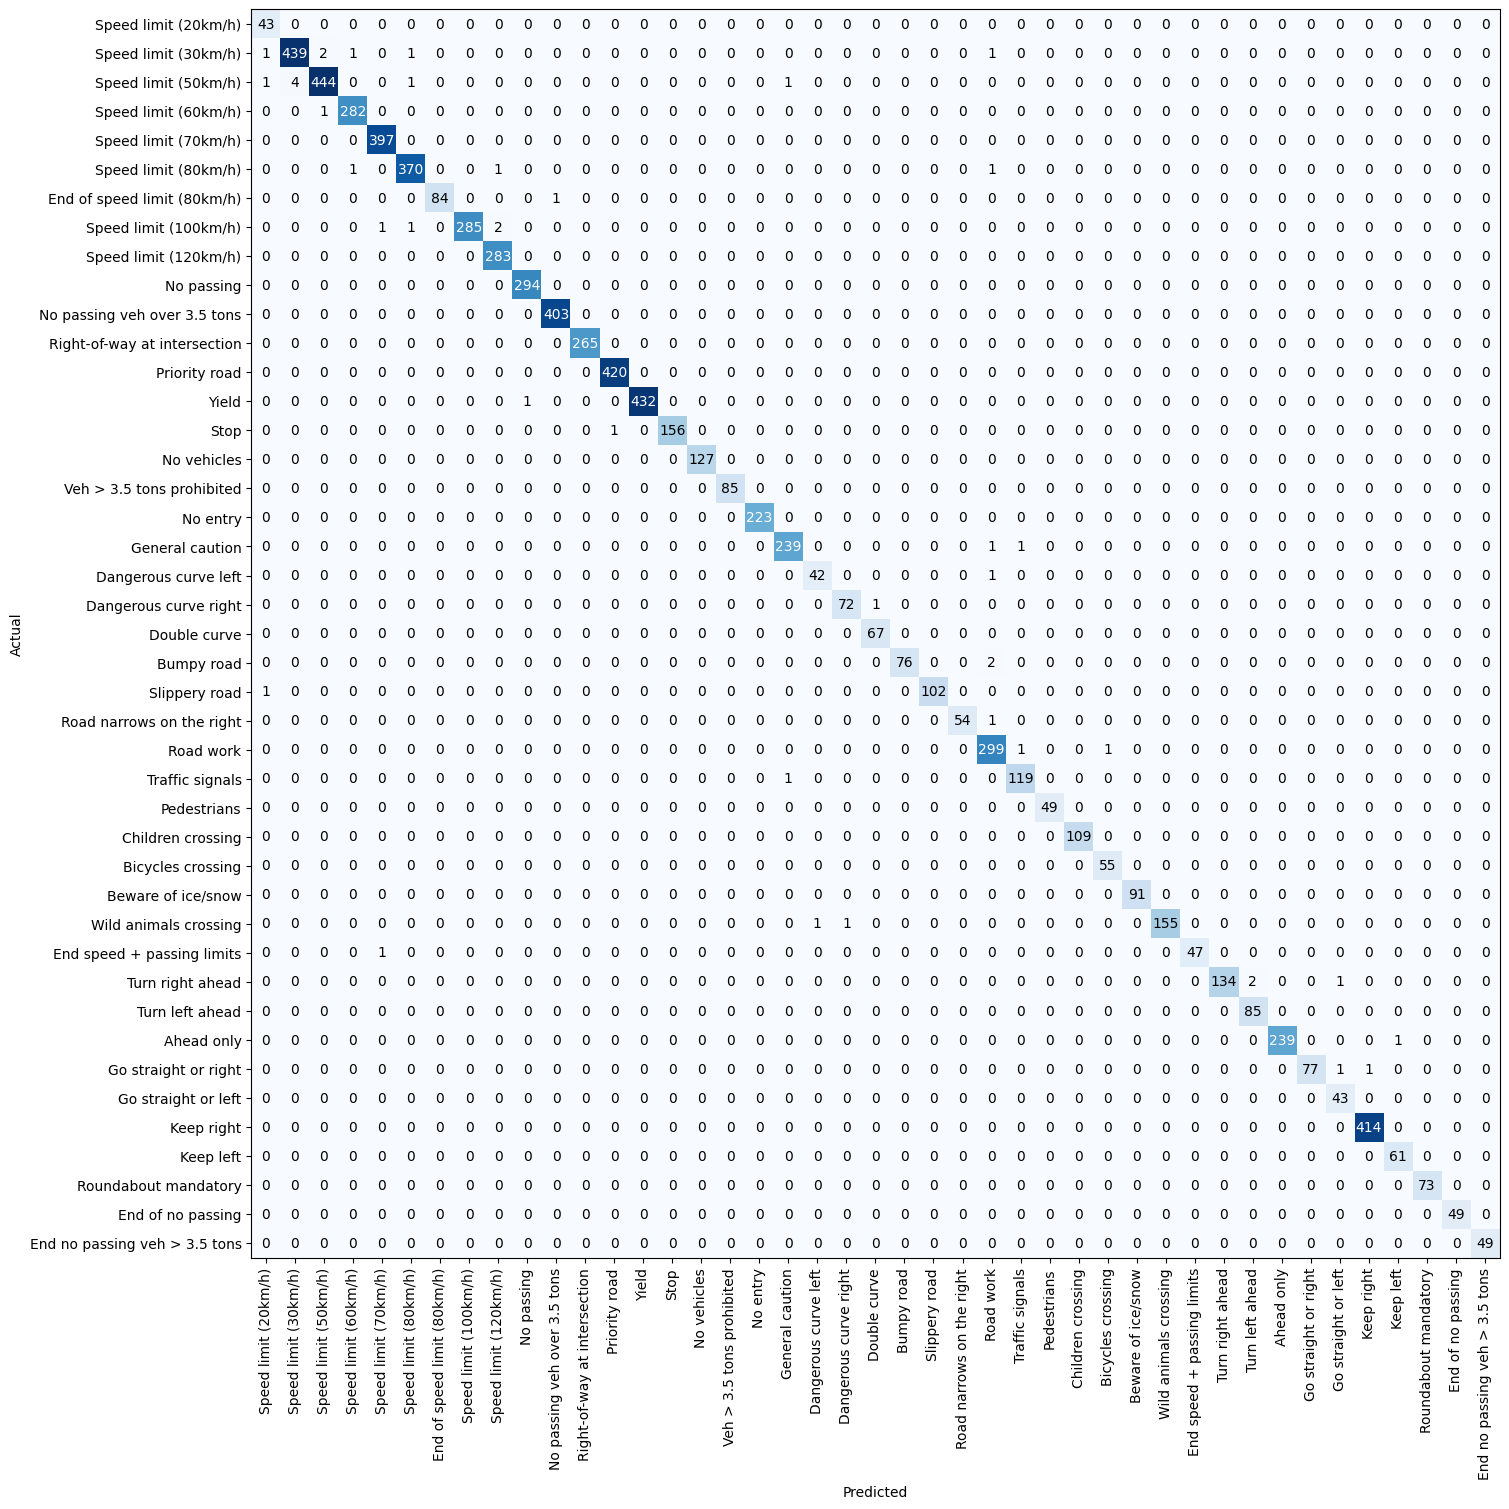

In [46]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [47]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [48]:
n_epochs = 80

valid_loss_min = np.Inf


for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.010385 	Validation Loss: 0.040461
Validation loss decreased (inf --> 0.040461).  Saving model ...
Epoch: 2 	Training Loss: 0.010294 	Validation Loss: 0.032827
Validation loss decreased (0.040461 --> 0.032827).  Saving model ...
Epoch: 3 	Training Loss: 0.010046 	Validation Loss: 0.034174
Epoch: 4 	Training Loss: 0.007955 	Validation Loss: 0.035071
Epoch: 5 	Training Loss: 0.005857 	Validation Loss: 0.032801
Validation loss decreased (0.032827 --> 0.032801).  Saving model ...
Epoch: 6 	Training Loss: 0.007491 	Validation Loss: 0.037744
Epoch: 7 	Training Loss: 0.006869 	Validation Loss: 0.039136
Epoch: 8 	Training Loss: 0.007123 	Validation Loss: 0.034535
Epoch: 9 	Training Loss: 0.006545 	Validation Loss: 0.029028
Validation loss decreased (0.032801 --> 0.029028).  Saving model ...
Epoch: 10 	Training Loss: 0.006319 	Validation Loss: 0.036095
Epoch: 11 	Training Loss: 0.005871 	Validation Loss: 0.030739
Epoch: 12 	Training Loss: 0.006361 	Validation Loss: 0.0

In [55]:
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
size=len(testset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size,43))
idx=0
model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)]=pred.to('cpu').numpy()
    all_classes[idx:idx+len(target)]=target.to('cpu').numpy()
    all_proba[idx:idx+len(target),:]=output.to('cpu').detach().numpy()
    idx+=len(target)


    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.020756

Test Accuracy of Speed limit (20km/h): 100.00% (43/43)
Test Accuracy of Speed limit (30km/h): 98.20% (437/445)
Test Accuracy of Speed limit (50km/h): 99.33% (448/451)
Test Accuracy of Speed limit (60km/h): 100.00% (283/283)
Test Accuracy of Speed limit (70km/h): 100.00% (397/397)
Test Accuracy of Speed limit (80km/h): 98.93% (369/373)
Test Accuracy of End of speed limit (80km/h): 98.82% (84/85)
Test Accuracy of Speed limit (100km/h): 98.96% (286/289)
Test Accuracy of Speed limit (120km/h): 100.00% (283/283)
Test Accuracy of No passing: 100.00% (294/294)
Test Accuracy of No passing veh over 3.5 tons: 100.00% (403/403)
Test Accuracy of Right-of-way at intersection: 100.00% (265/265)
Test Accuracy of Priority road: 100.00% (420/420)
Test Accuracy of Yield: 100.00% (433/433)
Test Accuracy of  Stop: 99.36% (156/157)
Test Accuracy of No vehicles: 100.00% (127/127)
Test Accuracy of Veh > 3.5 tons prohibited: 100.00% (85/85)
Test Accuracy of No entry: 100.00% (223/223)
Tes

### Visualize Sample Test Results

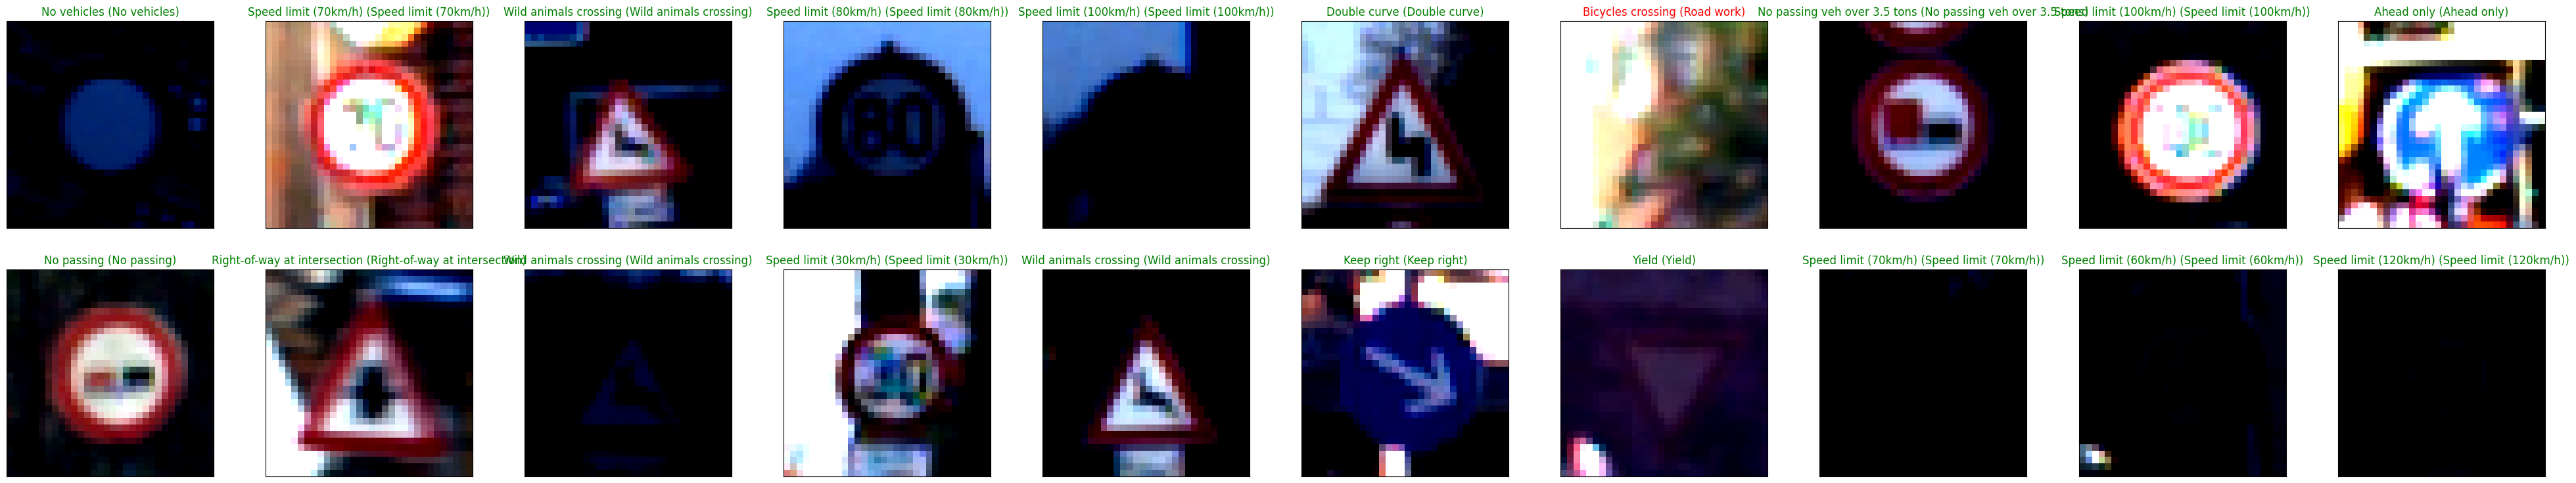

In [56]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()


if train_on_gpu:
    images = images.cuda()


output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(50, 9))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Confusion matrix

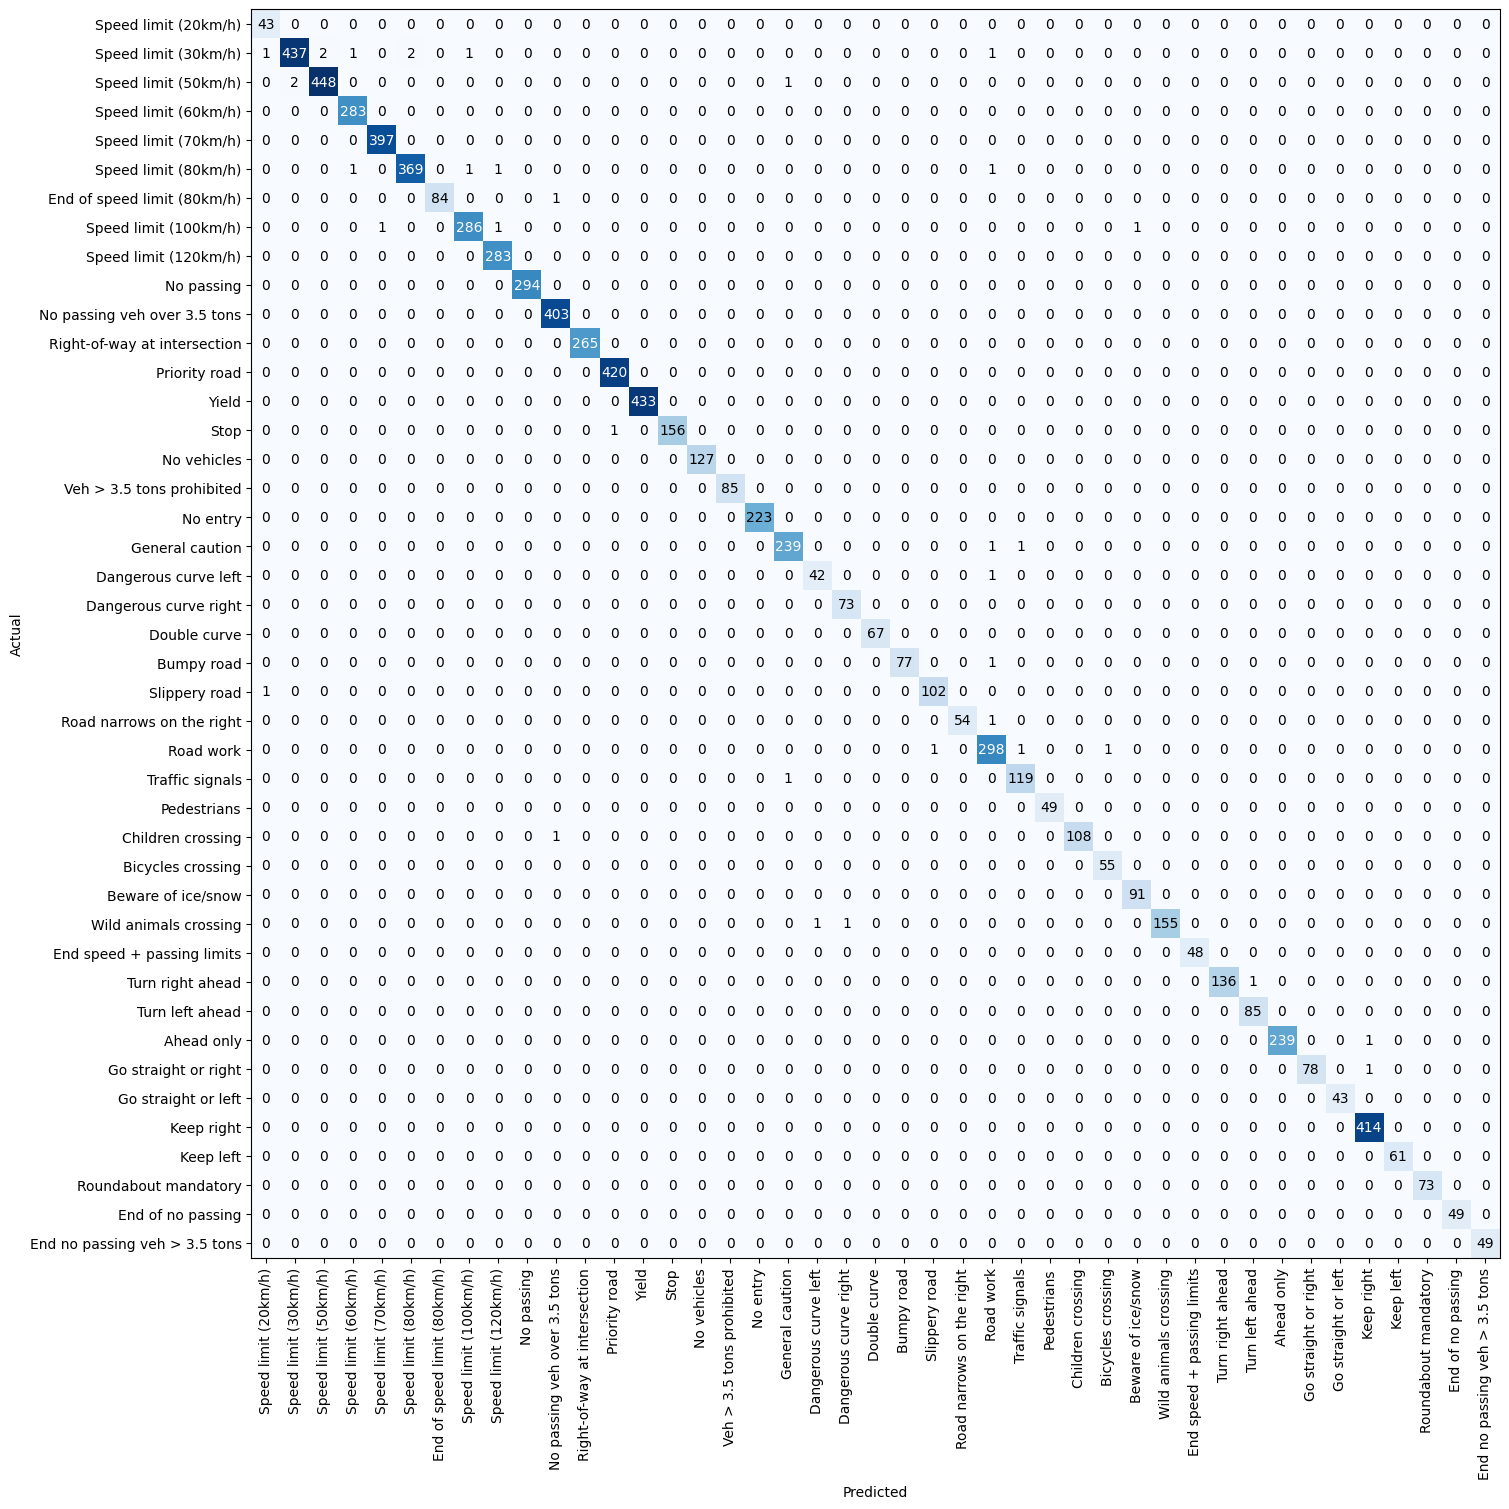

In [57]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [ ]:
import matplotlib.pyplot as plt

# Test accuracies for each category
accuracies = {
    "Speed limit (20km/h)": 100.00,
    "Speed limit (30km/h)": 99.55,
    "Speed limit (50km/h)": 99.33,
    "Speed limit (60km/h)": 99.29,
    "Speed limit (70km/h)": 100.00,
    "Speed limit (80km/h)": 99.46,
    "End of speed limit (80km/h)": 98.82,
    "Speed limit (100km/h)": 100.00,
    "Speed limit (120km/h)": 99.65,
    "No passing": 100.00,
    "No passing veh over 3.5 tons": 100.00,
    "Right-of-way at intersection": 100.00,
    "Priority road": 100.00,
    "Yield": 100.00,
    "Stop": 100.00,
    "No vehicles": 100.00,
    "Veh > 3.5 tons prohibited": 100.00,
    "No entry": 99.55,
    "General caution": 99.58,
    "Dangerous curve left": 100.00,
    "Dangerous curve right": 98.63,
    "Double curve": 100.00,
    "Bumpy road": 100.00,
    "Slippery road": 100.00,
    "Road narrows on the right": 100.00,
    "Road work": 99.67,
    "Traffic signals": 98.35,
    "Pedestrians": 100.00,
    "Children crossing": 99.08,
    "Bicycles crossing": 100.00,
    "Beware of ice/snow": 100.00,
    "Wild animals crossing": 100.00,
    "End speed + passing limits": 100.00,
    "Turn right ahead": 98.55,
    "Turn left ahead": 100.00,
    "Ahead only": 100.00,
    "Go straight or right": 100.00,
    "Go straight or left": 100.00,
    "Keep right": 99.76,
    "Keep left": 100.00,
    "Roundabout mandatory": 100.00,
    "End of no passing": 100.00,
    "End no passing veh > 3.5 tons": 100.00
}

# Overall accuracy
overall_accuracy = 99.73

# Plotting
plt.figure(figsize=(12, 20))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Test Accuracy for Each Traffic Signal Category')
plt.xlim(95, 100)  # Adjust the range to focus on differences
plt.axvline(x=overall_accuracy, color='green', linestyle='--')
plt.text(overall_accuracy + 0.1, len(accuracies) / 2, f'Overall Accuracy: {overall_accuracy}%', color='green', verticalalignment='center')
plt.show()


# Saving and loading networks

In [59]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [60]:
torch.save(model.state_dict(), 'checkpoint.pth')